In [1]:
import numpy as np
import pandas as pd
import torch

import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data

# importing for stochastic gradient descent
from torch.autograd import Variable
import matplotlib.pyplot as plt
import csv

In [2]:
movies = pd.read_csv('/kaggle/input/movies-dataset/movies.dat', sep = '::', header = None, engine = 'python',encoding = 'latin-1')
users = pd.read_csv('/kaggle/input/movies-dataset/users.dat', sep = '::', header = None, engine = 'python',encoding = 'latin-1')
ratings = pd.read_csv('/kaggle/input/movies-dataset/ratings.dat', sep = '::', header = None, engine = 'python',encoding = 'latin-1')

In [3]:
movies.columns = ['MovieID', 'Title', 'Genres']
ratings.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
users.columns = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip Code']

In [4]:
# Preparing the training set and test set(UserID::MovieID::Rating::Timestamp)
training_set = pd.read_csv('/kaggle/input/movies11/u1.base', delimiter = '\t')
training_set = np.array(training_set, dtype = 'int')
test_set = pd.read_csv('/kaggle/input/movies11/u1.test', delimiter = '\t')
test_set = np.array(test_set, dtype = 'int')

# Getting the number of users and movies
nb_users = int(max(max(training_set[:,0]), max(test_set[:,0])))
nb_movies = int(max(max(training_set[:,1]), max(test_set[:,1])))

In [5]:
# Converting the data into an array with users in lines and movies in columns
def convert(data):
    new_data = []
    for id_users in range(1, nb_users + 1):
        id_movies = data[:,1][data[:,0] == id_users]
        id_ratings = data[:,2][data[:,0] == id_users]
        ratings = np.zeros(nb_movies)
        ratings[id_movies - 1] = id_ratings
        new_data.append(list(ratings))
    return new_data
training_set = convert(training_set)
test_set = convert(test_set)


In [6]:
#Converting the data into torch tensor
training_set = torch.FloatTensor(training_set)
test_set = torch.FloatTensor(test_set)

#Converting the ratings into binary ratings 1(Liked) or 0(Not Liked)
training_set[training_set == 0] == -1
training_set[training_set == 1] == 0
training_set[training_set == 2] == 0
training_set[training_set >= 3] == 1
test_set[test_set == 0] == -1
test_set[test_set == 1] == 0
test_set[test_set == 2] == 0
test_set[test_set >= 3] == 1   

tensor([False, False, False,  ..., False, False, False])

In [7]:
#Converting the architecture of the Neural Networks
class RBM():
    def __init__(self, nv, nh):
        self.W = torch.randn(nh, nv)
        # bias corresponding to the hidden nodes
        self.a = torch.randn(1, nh)
        # bias corresponding to the visible nodes
        self.b = torch.randn(1, nv)

    def sample_h(self, x):
        wx = torch.mm(x, self.W.t())
        activation = wx + self.a.expand_as(wx)
        p_h_given_v = torch.sigmoid(activation)
        return p_h_given_v, torch.bernoulli(p_h_given_v)

    def sample_v(self, y):
        wy = torch.mm(y, self.W)
        activation = wy + self.b.expand_as(wy)
        p_v_given_h = torch.sigmoid(activation)
        return p_v_given_h, torch.bernoulli(p_v_given_h)

    def train(self, v0, vk, ph0, phk):
        #a = torch.mm(v0.t(), ph0) 
        #b = torch.mm(vk.t(), phk)
        #print(a.shape, b.shape, self.W.shape)
        self.W += (torch.mm(v0.t(), ph0) - torch.mm(vk.t(), phk)).T
        self.b += torch.sum((v0 - vk), 0)
        self.a += torch.sum((ph0 - phk), 0)
    def predict(self, x): # x: visible nodes
        _, h = self.sample_h( x)
        _, v = self.sample_v( h)
        return v

In [8]:
nv = len(training_set[0])
nh = 100
batch_size = 943
rbm = RBM(nv, nh)
error = []

# Training the RBM
nb_epoch = 100
for epoch in range(1, nb_epoch + 1):
    train_loss = 0
    s = 0.
    for id_user in range(0, nb_users - 100, batch_size):
        vk = training_set[id_user:id_user+batch_size]
        v0 = training_set[id_user:id_user+batch_size]
        ph0,_ = rbm.sample_h(v0)
        for k in range (10):
            _,hk = rbm.sample_h(vk)
            _,vk = rbm.sample_v(hk)
            vk[v0<0] = v0[v0<0]
        phk,_ = rbm.sample_h(vk)
        rbm.train(v0,vk,ph0,phk)
        train_loss += torch.mean(torch.abs(v0[v0>=0] - vk[v0>=0]))
        s += 1.
    print('epoch: '+str(epoch)+' loss: '+str(train_loss/s))
    error.append(float(train_loss/s))

epoch: 1 loss: tensor(0.6452)
epoch: 2 loss: tensor(0.4118)
epoch: 3 loss: tensor(0.2956)
epoch: 4 loss: tensor(0.2834)
epoch: 5 loss: tensor(0.2500)
epoch: 6 loss: tensor(0.3062)
epoch: 7 loss: tensor(0.3094)
epoch: 8 loss: tensor(0.2534)
epoch: 9 loss: tensor(0.2836)
epoch: 10 loss: tensor(0.2709)
epoch: 11 loss: tensor(0.2821)
epoch: 12 loss: tensor(0.2602)
epoch: 13 loss: tensor(0.2737)
epoch: 14 loss: tensor(0.2579)
epoch: 15 loss: tensor(0.2718)
epoch: 16 loss: tensor(0.2734)
epoch: 17 loss: tensor(0.2651)
epoch: 18 loss: tensor(0.2696)
epoch: 19 loss: tensor(0.2818)
epoch: 20 loss: tensor(0.2756)
epoch: 21 loss: tensor(0.2660)
epoch: 22 loss: tensor(0.2939)
epoch: 23 loss: tensor(0.2495)
epoch: 24 loss: tensor(0.2715)
epoch: 25 loss: tensor(0.2759)
epoch: 26 loss: tensor(0.2720)
epoch: 27 loss: tensor(0.2926)
epoch: 28 loss: tensor(0.2685)
epoch: 29 loss: tensor(0.2688)
epoch: 30 loss: tensor(0.2838)
epoch: 31 loss: tensor(0.2771)
epoch: 32 loss: tensor(0.2778)
epoch: 33 loss: t

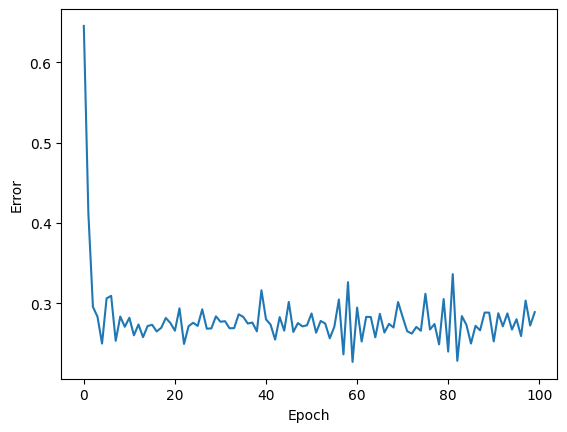

In [9]:
plt.plot(error)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

In [10]:
# Testing the RBM    
test_loss = 0
s = 0.
for id_user in range(nb_users):
    v = training_set[id_user:id_user+1]
    vt = test_set[id_user:id_user+1]
    if len(vt[vt>=0]) > 0:
        _,h = rbm.sample_h(v)
        _,v = rbm.sample_v(h)
        test_loss += torch.mean(torch.abs(vt[vt>=0] - v[vt>=0]))
        s += 1.
print('test loss: '+str(test_loss/s))

test loss: tensor(0.1956)


In [11]:
prediction = rbm.predict(vk)
print(prediction)

#Converting torch tensor to array
prediction = torch.Tensor.numpy(prediction)

#Deleting 1st Column
prediction = np.delete(prediction,np.s_[0:1], axis=1)

#movies title
movie_title = pd.read_csv('/kaggle/input/movies-dataset/movies.dat', sep = '::', header = None, engine = 'python',encoding = 'latin-1')
title = movie_title.iloc[0:1681, 1].values
print (title)

tensor([[1., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.]])
['Toy Story (1995)' 'Jumanji (1995)' 'Grumpier Old Men (1995)' ...
 'Horse Whisperer, The (1998)' 'Winter Guest, The (1997)'
 'Jackie Brown (1997)']


In [12]:
#Converting to dataframe
title = pd.DataFrame(title)
title = np.reshape(title, 1681)
pred_result = pd.DataFrame(prediction)

print(title.shape)
#Converting to numpy array to make row as column and again coverting to dataframe
#title=title.values
#array to 1D
title=title.reshape((1, -1))
title = pd.DataFrame(title)

#Merging title and pred_result
frame = [title,pred_result]
result = pd.concat(frame)
#result = title.append(pred_result)

#Merging UserID with Result
user_id=users.iloc[0:943, 0].values
user_id=pd.DataFrame(user_id)
result=pd.concat([user_id, result], axis=1)

#result.iloc[[0], [0]] = 0
#result.at[0, 0] = 'User-id'

result.to_csv('output.csv', encoding='utf-8')

with open('output.csv', 'w') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerows(prediction)
    
csv_file.close()

(1681,)
